In [1]:
# Rotating 4D plots and other for Growth of Structure 2021 https://growthofstructure.sites.ucsc.edu/
# Using getdist (getdist.readthedocs.org) latest git master
# I might tidy up the 3d scatter code into a general getdist function at some point..


%matplotlib notebook
import matplotlib
#matplotlib.use("Agg") # this seems to have some bugs with rotation output in matplotlib 3.4
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import numpy as np
from getdist.plots import MCSampleAnalysis
from getdist import plots

analysis_settings=None
# analysis_settings = {'ignore_rows': 0.3} # set this if not using burnin-removed chains

# directories to search for chains matching names, here using public Planck chain grid, change path appropriately
# not actually using getdist to plot here, just manage grid lookup/chain load
loader = MCSampleAnalysis(['C:\\Tmp\\Planck\\2017\\Dec17'], settings=analysis_settings)


<IPython.core.display.Javascript object>


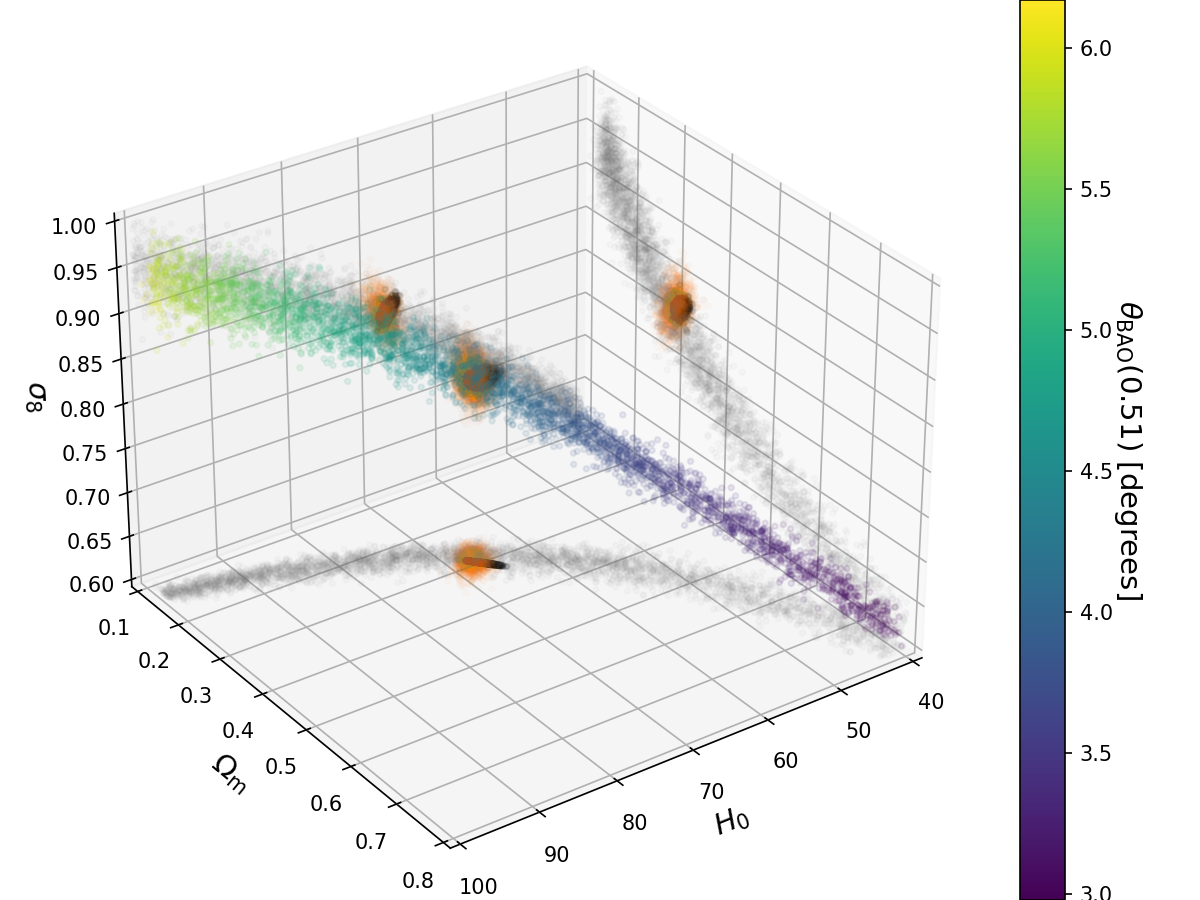

In [2]:
# some options
DES=False
TTTEEE=True
BAO=True
shadows=True
colorbar=True
animate=True
export_mp4=False
alpha=0.1
thin=2 # increase a lot for quick preview
scatter_size=7

priors = 'lenspriors'

omm_lim=(0.1,0.8)
H0_lim=(40,100)
s8_lim=(0.6,1)


if DES:
    omm_lim=(0.1,0.8)
    H0_lim=(40,100)
    s8_lim=(0.6,1.2)
    
if priors == 'DESpriors':
    H0_lim=(55,91)
    omm_lim=(0.1,0.9)
    alpha=0.3
    thin=1



def load(name, thin=thin):    
    samps= loader.samples_for_root(name)
    ix = samps.random_single_samples_indices(thin=thin)
    ix = ix[samps['omegam'][ix]<omm_lim[1]]
    ix = ix[samps['omegam'][ix]>omm_lim[0]]
    ix = ix[samps['sigma8'][ix]<s8_lim[1]]
    ix = ix[samps['sigma8'][ix]>s8_lim[0]]
    ix = ix[samps['H0'][ix]<H0_lim[1]]
    ix = ix[samps['H0'][ix]>H0_lim[0]]
    
    return samps, ix


fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig)

samps, ix = load('base_lensing_%s'%priors)
# color by theta_BAO
colors = samps['rdrag'][ix]/samps['DM051'][ix]/np.pi*180

scat=ax.scatter(samps['H0'][ix], samps['omegam'][ix], samps['sigma8'][ix], c = colors, marker='o', 
           depthshade=True, alpha=alpha,s =scatter_size)
ax.set_xlabel('$H_0$', fontsize=14)
ax.set_xlim(H0_lim)

ax.set_ylabel(r'$\Omega_{\rm m}$', fontsize=14)
ax.set_ylim(omm_lim)

ax.set_zlabel(r'$\sigma_8$', fontsize=14)
ax.set_zlim(s8_lim)

if colorbar:
    from matplotlib import cm
    mappable = cm.ScalarMappable(plt.Normalize(colors.min(), colors.max()))
    mappable.set_array(colors)
    cb=fig.colorbar(mappable)
    cb.set_alpha(1)
    cb.set_label(r'$\theta_{\rm BAO}(0.51)$ [degrees]', rotation=-90, labelpad=15, fontsize=14)

def scatter_shadows(x,y,z, x0,y0,z0, c='gray', marker='o', alpha=0.03, s=scatter_size):
    ax.scatter(x, y, z*0+z0, c = c, marker=marker, alpha=alpha,s =s)
    ax.scatter(x*0+x0, y, z, c = c, marker=marker, alpha=alpha,s =s)
    ax.scatter(x, y*0+y0, z, c = c, marker=marker, alpha=alpha,s =s)
    
if shadows:
    scatter_shadows(samps['H0'][ix], samps['omegam'][ix], samps['sigma8'][ix], H0_lim[0],omm_lim[0],s8_lim[0])
    
if BAO:
    c='C1'
    samps, ix = load('base_lensing_BAO_%s'%priors, thin=5)
    ax.scatter(samps['H0'][ix], samps['omegam'][ix], samps['sigma8'][ix], c = c, marker='o', 
               depthshade=True, alpha=0.02)
    
    scatter_shadows(samps['H0'][ix], samps['omegam'][ix], samps['sigma8'][ix], 
                        H0_lim[0],omm_lim[0],s8_lim[0], c=c,alpha=0.02)
    
if TTTEEE:
    c='k'
    samps, ix = load('base_plikHM_TTTEEE_lowl_lowE', thin=5)
    ax.scatter(samps['H0'][ix], samps['omegam'][ix], samps['sigma8'][ix], c = c, marker='o', 
               depthshade=True, alpha=0.04)
    if shadows:
        scatter_shadows(samps['H0'][ix], samps['omegam'][ix], samps['sigma8'][ix], 
                        H0_lim[0],omm_lim[0],s8_lim[0], c=c, alpha=0.1)

    
if DES:
    samps, ix = load('base_DESlens_%s'%priors, thin=1)
    ax.scatter(samps['H0'][ix], samps['omegam'][ix], samps['sigma8'][ix], c = 'C3', marker='o', 
               depthshade=True, alpha =0.1)
    
 

ax.view_init(azim=77)
#ax.view_init(azim=25, elev=15)


if animate:

    def rotate(angle):
        ax.view_init(azim=angle)

    # note this is slow in notebook when using low thin factors
    rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0,360.1,0.6),interval=50)
    if export_mp4:
        # need ffmpeg installed
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=15, bitrate=1800)

        if DES:
            rot_animation.save(r'c:\tmp\lensonly_DES_%s.mp4'%priors, writer=writer)
        else:
            rot_animation.save(r'c:\tmp\lensonly_%s.mp4'%priors, writer=writer)

(2.0, 2501.0)

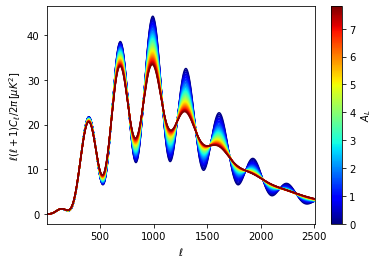

In [3]:
# CAMB parameter plots, need camb installed from github (https://github.com/cmbant/CAMB)
# takes a few minutes or so to run
%matplotlib inline
import camb
import os
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt

# Alens

ini = os.path.join(os.path.dirname(camb.__file__),'..','inifiles', 'planck_2018.ini')
pars = camb.read_ini(ini)
cls=[]
Als = np.arange(0,8, 0.2) # increase last number to make run quickly for testing
for Alens in Als:
    pars.Alens=Alens
    pars.set_for_lmax(3000)
    data = camb.get_results(pars)
    cl = data.get_lensed_scalar_cls(CMB_unit='muK')
    cls.append(cl)
lmax=2501

cmap = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=Als[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap.set_array(Als)
plt.figure(figsize=(6,4))
for cl,AL in zip(cls,Als):
    plt.plot(np.arange(2, lmax+1), cl[2:lmax+1,1], color=scalarMap.to_rgba(AL))
plt.xlabel('$\ell$')
plt.ylabel('$\ell(\ell+1)C_\ell/2\pi\,[\mu K^2]$')
cb=plt.colorbar(scalarMap)
cb.set_label('$A_L$')
plt.xlim(2,lmax)

<ErrorbarContainer object of 3 artists>

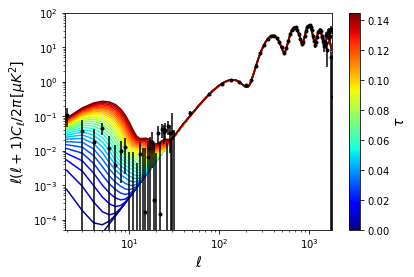

In [4]:
# tau dependence keeping As exp(-2tau) fixed
pars = camb.read_ini(ini)
cls=[]
taus = np.arange(0,0.15, 0.005)
Astau = pars.InitPower.As*np.exp(-2*pars.Reion.optical_depth)
for tau in taus:
    pars.Reion.optical_depth=tau
    pars.InitPower.As = Astau*np.exp(2*tau)
    pars.set_for_lmax(3000)
    data = camb.get_results(pars)
    cl = data.get_lensed_scalar_cls(CMB_unit='muK')
    cls.append(cl)
    
lmax=1801
cmap = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=taus[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap.set_array(taus)
plt.figure(figsize=(6,4))
calplanck=1.00044
for cl,tau in zip(cls,taus):
    plt.loglog(np.arange(2, lmax+1), cl[2:lmax+1,1]/calplanck**2, color=scalarMap.to_rgba(tau))
fs=14
plt.xlabel('$\ell$', fontsize=fs)
plt.ylabel('$\ell(\ell+1)C_\ell/2\pi\,[\mu K^2]$', fontsize=fs)
cb=plt.colorbar(scalarMap)
cb.set_label(r'$\tau$', fontsize=fs)
plt.xlim(1.9,lmax)
plt.ylim(5e-5,1e2)
# These files available from the planck PLA
d = np.loadtxt(r'c:\tmp\planck\2017\COM_PowerSpect_CMB-EE-binned_R3.02.txt')
plt.errorbar(d[:,0], d[:,1], d[:,2], d[:,3], fmt='.', color='k')
d = np.loadtxt(r'c:\tmp\planck\2017\COM_PowerSpect_CMB-EE-full_R3.01.txt')
mx=30
plt.errorbar(d[:30,0], d[:30,1], d[:30,2], d[:30,3], fmt='.', color='k',zorder=10000)
#plt.savefig('z://EE_tau.png', dpi=300, bbox_inches='tight')

In [ ]:
# Other parameter plots made with getdist-gui or standard getdist scripts